**Import TensorFlow and other libraries**

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

**Download and explore the dataset**

In [11]:
import pathlib
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [12]:
data_dir = "/content/gdrive/MyDrive/cars"
data_dir = pathlib.Path(data_dir)

**copy of the dataset available**

In [13]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1943


**Some Audi**

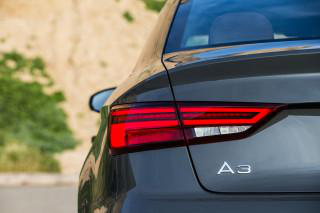

In [14]:
audi = list(data_dir.glob('audi/*'))
PIL.Image.open(str(audi[0]))

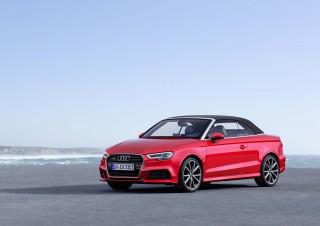

In [15]:
PIL.Image.open(str(audi[1]))

**Some Lamborghini**

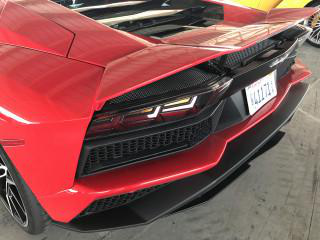

In [16]:
lamborghini = list(data_dir.glob('lamborghini/*'))
PIL.Image.open(str(lamborghini[0]))

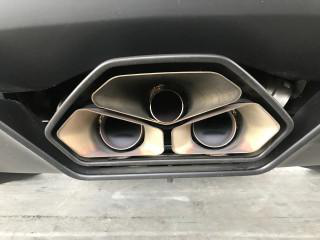

In [17]:
PIL.Image.open(str(lamborghini[1]))

**Create a dataset**

In [18]:
batch_size = 32
img_height = 180
img_width = 180

In [19]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1943 files belonging to 5 classes.
Using 1555 files for training.


In [20]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1943 files belonging to 5 classes.
Using 388 files for validation.


In [21]:
class_names = train_ds.class_names
print(class_names)


['audi', 'ferrari', 'jaguar', 'lamborghini', 'mercedes']


**Visualize the data**

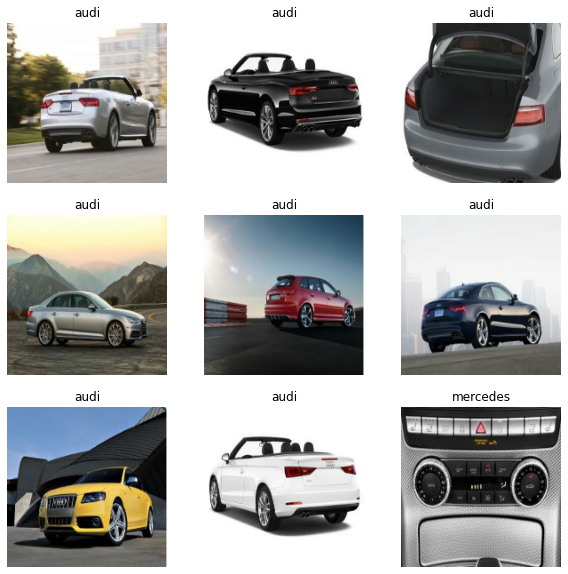

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [23]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


**Configure the dataset for performance**

In [24]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Standardize the data**

In [25]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [26]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


**Create the model**

In [27]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

**Compile the model**

In [28]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

**Model summary**

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

**Train the model**

In [30]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
49/49 [==============================] - 143s 2s/step - loss: 1.2625 - accuracy: 0.5749 - val_loss: 1.0844 - val_accuracy: 0.5979
Epoch 2/10
49/49 [==============================] - 2s 41ms/step - loss: 0.9690 - accuracy: 0.6251 - val_loss: 1.0312 - val_accuracy: 0.6237
Epoch 3/10
49/49 [==============================] - 2s 40ms/step - loss: 0.7294 - accuracy: 0.7177 - val_loss: 0.9621 - val_accuracy: 0.6624
Epoch 4/10
49/49 [==============================] - 2s 40ms/step - loss: 0.4604 - accuracy: 0.8289 - val_loss: 0.9585 - val_accuracy: 0.6804
Epoch 5/10
49/49 [==============================] - 2s 40ms/step - loss: 0.2417 - accuracy: 0.9196 - val_loss: 1.1191 - val_accuracy: 0.6907
Epoch 6/10
49/49 [==============================] - 2s 40ms/step - loss: 0.1392 - accuracy: 0.9569 - val_loss: 1.4111 - val_accuracy: 0.7010
Epoch 7/10
49/49 [==============================] - 2s 40ms/step - loss: 0.0540 - accuracy: 0.9852 - val_loss: 1.4325 - val_accuracy: 0.7010
Epoch 8/10
49

**Visualize training results**

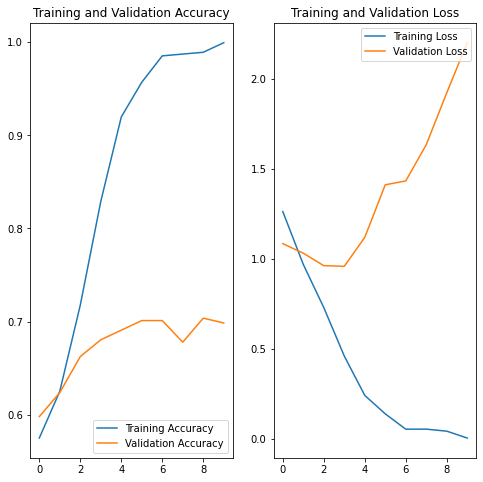

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Data augmentation**

In [32]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

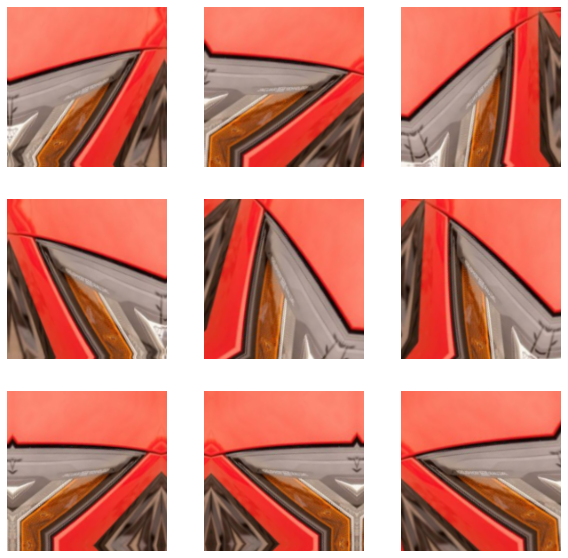

In [33]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

**Dropout**

In [34]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

**Compile and train the model**

In [35]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [36]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [37]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
49/49 [==============================] - 3s 51ms/step - loss: 1.2469 - accuracy: 0.5621 - val_loss: 1.1495 - val_accuracy: 0.5876
Epoch 2/15
49/49 [==============================] - 2s 46ms/step - loss: 1.1106 - accuracy: 0.5961 - val_loss: 1.0970 - val_accuracy: 0.5902
Epoch 3/15
49/49 [==============================] - 2s 46ms/step - loss: 1.0686 - accuracy: 0.6058 - val_loss: 1.0370 - val_accuracy: 0.5979
Epoch 4/15
49/49 [==============================] - 2s 46ms/step - loss: 1.0051 - accuracy: 0.6206 - val_loss: 1.0009 - val_accuracy: 0.6237
Epoch 5/15
49/49 [==============================] - 2s 46ms/step - loss: 0.9552 - accuracy: 0.6360 - val_loss: 0.9824 - val_accuracy: 0.6289
Epoch 6/15
49/49 [==============================] - 2s 46ms/step - loss: 0.8970 - accuracy: 0.6579 - val_loss: 0.9964 - val_accuracy: 0.6418
Epoch 7/15
49/49 [==============================] - 2s 46ms/step - loss: 0.8572 - accuracy: 0.6836 - val_loss: 1.0706 - val_accuracy: 0.6443
Epoch 8/15
49

**Visualize training results**

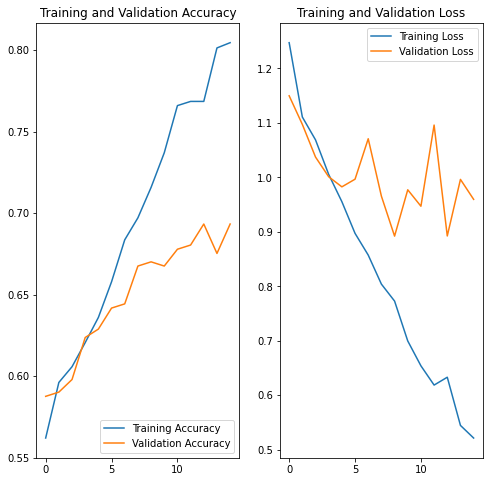

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Predict on new data**

In [39]:
ferrari_dir = "/content/gdrive/MyDrive/cars/ferrari/Ferrari_488 GTB_2016_245_20_660_39_8_76_47_179_15_RWD_2_2_2dr_EXb.jpg"
data_dir = pathlib.Path(data_dir)


img = keras.preprocessing.image.load_img(
    ferrari_dir, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to lamborghini with a 35.37 percent confidence.
